In [ ]:
# NEU-DET Dataset
from google.colab import files
import zipfile, os

uploaded = files.upload()
zip = list(uploaded.keys())[0]
dir = "NEU_Surface_Defects"
os.makedirs(dir, exist_ok=True)
with zipfile.ZipFile(zip, "r") as zip_ref:
    zip_ref.extractall(dir)

# Masire sahihe pusheha
train_images_dir = os.path.join(dir, "NEU-DET", "train", "images")
val_images_dir   = os.path.join(dir, "NEU-DET", "validation", "images")

# Sehate vujude dadeha
if not (os.path.isdir(train_images_dir) and os.path.isdir(val_images_dir)):
    for root, dirs, files in os.walk(dir):
        print(f" {root} --> {dirs}")
    raise ValueError("Pusheha peyda nashodand")
else:
    print(f"Masire sahih peida shod: \n  Amuzesh: {train_images_dir}\n  Azmoon: {val_images_dir}")

# Bargozarie dadeha ba image_dataset_from_directory
import tensorflow as tf

img_height, img_width = 200, 200
batch_size = 1800  # Kole dadeha yekja

train_ds = tf.keras.utils.image_dataset_from_directory(train_images_dir,labels="inferred",
                                                       label_mode="int",color_mode="grayscale",
                                                       batch_size=batch_size,
                                                       image_size=(img_height, img_width),
                                                       shuffle=True,seed=42,)

val_ds = tf.keras.utils.image_dataset_from_directory(val_images_dir,labels="inferred",
                                                     label_mode="int",color_mode="grayscale",
                                                     batch_size=batch_size,
                                                     image_size=(img_height, img_width),
                                                     shuffle=False,)

# Tabdil be NumPy
for images, labels in train_ds.take(1):
    X_train = images.numpy()
    y_train = labels.numpy()

for images, labels in val_ds.take(1):
    X_test = images.numpy()
    y_test = labels.numpy()

# Normalsazi
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Abaade nahayi
print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation/Test set shape: {X_test.shape}, Labels: {y_test.shape}")


Saving NEU-DET Dataset.zip to NEU-DET Dataset (1).zip
Masire sahih peida shod: 
  Amuzesh: NEU_Surface_Defects/NEU-DET/train/images
  Azmoon: NEU_Surface_Defects/NEU-DET/validation/images
Found 1440 files belonging to 6 classes.
Found 360 files belonging to 6 classes.
Training set shape: (1440, 200, 200, 1), Labels: (1440,)
Validation/Test set shape: (360, 200, 200, 1), Labels: (360,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np


print("Before one-hot:", y_train.shape, y_test.shape)

# Agar y_train besoorate label adadi bashad
if len(y_train.shape) == 1 or y_train.shape[1] == 1:
    y_train = to_categorical(y_train, num_classes=6)
    y_test = to_categorical(y_test, num_classes=6)

print("After one-hot:", y_train.shape, y_test.shape)

# CNN
model = Sequential()

# Block1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # 6 کلاس

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Amuzesh
history = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,
                    batch_size=32,verbose=2)


Before one-hot: (1440,) (360,)
After one-hot: (1440, 6) (360, 6)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,575,366 (78.49 MB)

 Trainable params: 20,574,918 (78.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
45/45 - 15s - 341ms/step - accuracy: 0.5708 - loss: 21.7802 - val_accuracy: 0.1667 - val_loss: 105.9845
Epoch 2/20
45/45 - 2s - 48ms/step - accuracy: 0.7174 - loss: 5.4410 - val_accuracy: 0.1806 - val_loss: 121.4806
Epoch 3/20
45/45 - 3s - 57ms/step - accuracy: 0.7340 - loss: 1.4752 - val_accuracy: 0.1667 - val_loss: 108.0863
Epoch 4/20
45/45 - 3s - 58ms/step - accuracy: 0.7507 - loss: 0.7898 - val_accuracy: 0.1667 - val_loss: 102.2594
Epoch 5/20
45/45 - 2s - 49ms/step - accuracy: 0.7701 - loss: 0.6768 - val_accuracy: 0.1639 - val_loss: 100.1073
Epoch 6/20
45/45 - 2s - 48ms/step - accuracy: 0.7542 - loss: 0.7094 - val_accuracy: 0.1667 - val_loss: 77.6508
Epoch 7/20
45/45 - 2s - 48ms/step - accuracy: 0.7542 - loss: 0.7516 - val_accuracy: 0.1639 - val_loss: 91.2274
Epoch 8/20
45/45 - 2s - 49ms/step - accuracy: 0.7535 - loss: 0.6669 - val_accuracy: 0.1667 - val_loss: 81.6702
Epoch 9/20
45/45 - 2s - 49ms/step - accuracy: 0.7437 - loss: 0.6776 - val_accuracy: 0.1611 - val_loss: 6

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Block1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # 6 class

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Amuzeshe model
history = model.fit(X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,batch_size=32,verbose=2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,575,366 (78.49 MB)

 Trainable params: 20,574,918 (78.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
45/45 - 11s - 254ms/step - accuracy: 0.5181 - loss: 4.5858 - val_accuracy: 0.1667 - val_loss: 5.5675
Epoch 2/20
45/45 - 2s - 54ms/step - accuracy: 0.7167 - loss: 0.7207 - val_accuracy: 0.1667 - val_loss: 3.9621
Epoch 3/20
45/45 - 2s - 52ms/step - accuracy: 0.7958 - loss: 0.5357 - val_accuracy: 0.1667 - val_loss: 3.4718
Epoch 4/20
45/45 - 3s - 57ms/step - accuracy: 0.8313 - loss: 0.4635 - val_accuracy: 0.1667 - val_loss: 3.5047
Epoch 5/20
45/45 - 3s - 56ms/step - accuracy: 0.8326 - loss: 0.4930 - val_accuracy: 0.1667 - val_loss: 2.4045
Epoch 6/20
45/45 - 3s - 60ms/step - accuracy: 0.8528 - loss: 0.4280 - val_accuracy: 0.1667 - val_loss: 2.9069
Epoch 7/20
45/45 - 2s - 50ms/step - accuracy: 0.8833 - loss: 0.2982 - val_accuracy: 0.1667 - val_loss: 4.1407
Epoch 8/20
45/45 - 3s - 60ms/step - accuracy: 0.8986 - loss: 0.2575 - val_accuracy: 0.1667 - val_loss: 4.3621
Epoch 9/20
45/45 - 2s - 53ms/step - accuracy: 0.9174 - loss: 0.2248 - val_accuracy: 0.1667 - val_loss: 5.8852
Epoch 10

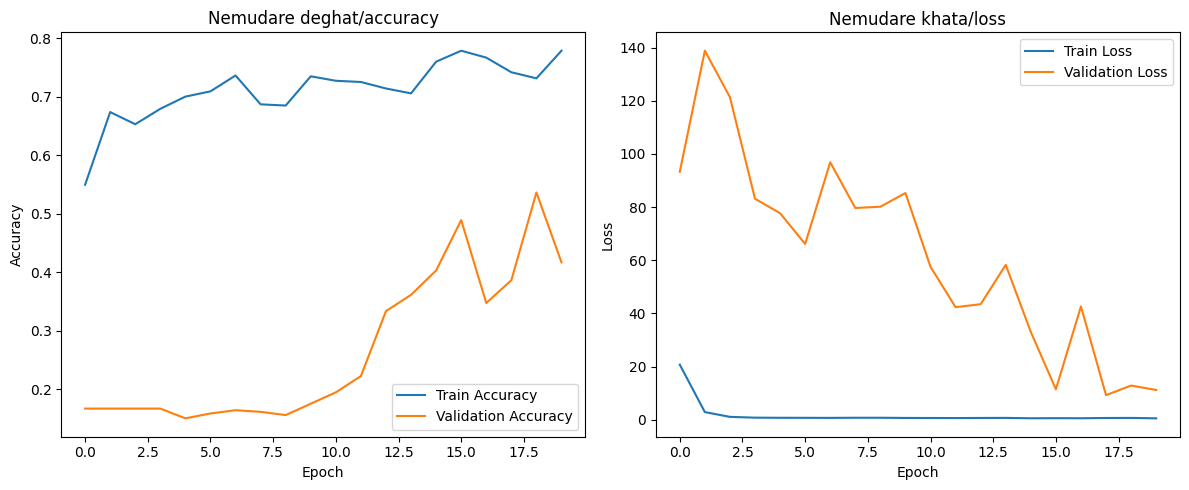

Deghate nahayie model ruye dadehaye azmun: 41.67%


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Deghat
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Nemudare deghat/accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Khata
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Nemudare khata/loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Deghate nahayie model ruye dadehaye azmun: {test_accuracy * 100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


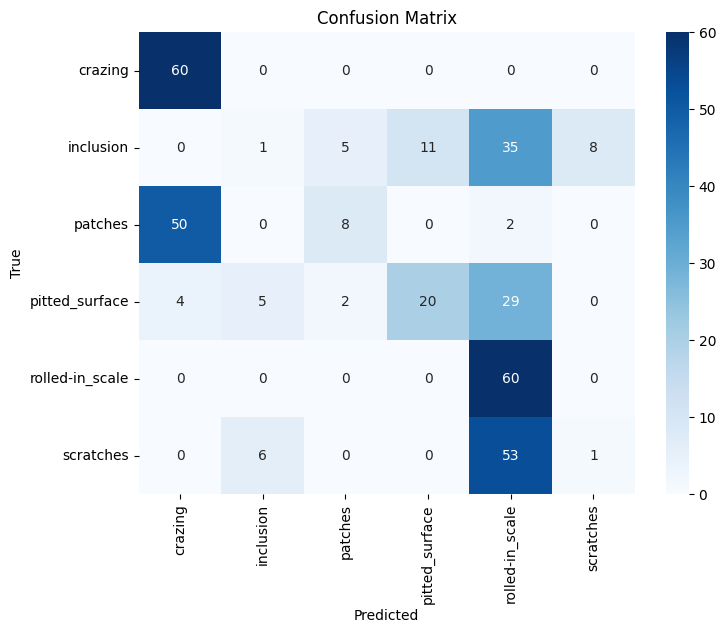

Classification Report:
                 precision    recall  f1-score   support

        crazing       0.53      1.00      0.69        60
      inclusion       0.08      0.02      0.03        60
        patches       0.53      0.13      0.21        60
 pitted_surface       0.65      0.33      0.44        60
rolled-in_scale       0.34      1.00      0.50        60
      scratches       0.11      0.02      0.03        60

       accuracy                           0.42       360
      macro avg       0.37      0.42      0.32       360
   weighted avg       0.37      0.42      0.32       360



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Pishbini ruye dadehaye azmoon
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matrix ashoftegi
cm = confusion_matrix(y_true, y_pred)
labels = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
کلاس‌ها: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


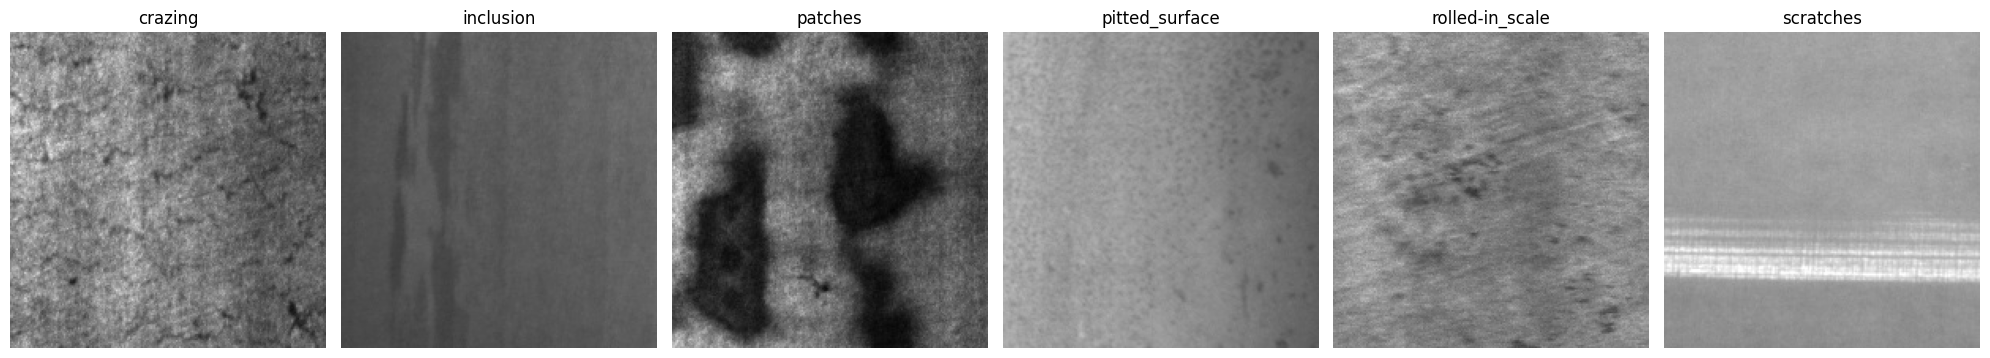

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import random

train_dir = '/content/NEU_Surface_Defects/NEU-DET/train/images'
val_dir = '/content/NEU_Surface_Defects/NEU-DET/validation/images'

# Andaze standard vurudie ResNet-50
Image_Size = (224, 224)
Batch_Size = 32
SEED = 42

# Tarife ImageDataGenerator ba Augmentation
train_data = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Normalsazi
)

# Datagenerator baraye pusheha
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=Image_Size,
    color_mode='rgb',
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_data.flow_from_directory(
    val_dir,
    target_size=Image_Size,
    color_mode='rgb',
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Nemuneye tasadofi az har class
class_names = list(train_generator.class_indices.keys())
print("classes:", class_names)

fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    img = plt.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!ls /content/NEU_Surface_Defects/NEU-DET




train  validation


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Abaade vurudi baraye ResNet50
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/NEU_Surface_Defects/NEU-DET/train/images',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    '/content/NEU_Surface_Defects/NEU-DET/validation/images',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Bargozarie model paye ResNet50 bedune layehaye balayi
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze kardane vaznha

# Afzudane layehaye jadid be balaye shabake
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Bargozarie ResNet-50 bedune laye khuruji
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Frezze kardane hame layeha
for layer in base_model.layers:
    layer.trainable = False

# Afzudane head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  # 6 کلاس

# Model nahayi
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Amuzeshe head
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 - 37s - 828ms/step - accuracy: 0.6736 - loss: 0.9989 - val_accuracy: 0.9556 - val_loss: 0.1542
Epoch 2/10
45/45 - 18s - 403ms/step - accuracy: 0.9319 - loss: 0.2185 - val_accuracy: 0.9833 - val_loss: 0.0950
Epoch 3/10
45/45 - 17s - 387ms/step - accuracy: 0.9514 - loss: 0.1444 - val_accuracy: 0.9667 - val_loss: 0.0819
Epoch 4/10
45/45 - 18s - 389ms/step - accuracy: 0.9625 - loss: 0.1123 - val_accuracy: 0.9778 - val_loss: 0.0589
Epoch 5/10
45/45 - 18s - 393ms/step - accuracy: 0.9778 - loss: 0.0775 - val_accuracy: 0.9861 - val_loss: 0.0401
Epoch 6/10
45/45 - 18s - 389ms/step - accuracy: 0.9701 - loss: 0.0915 - val_accuracy: 0.9806 - val_loss: 0.0536
Epoch 7/10
45/45 - 20s - 454ms/step - accuracy: 0.9764 - loss: 0.0684 - val_accuracy: 0.9806 - val_loss: 0.0437
Epoch 8/10
45/45 - 18s - 403ms/step - accuracy: 0.9799 - loss: 0.0656 - val_accuracy: 0.9889 - val_loss: 0.0276
Epoch 9/10
45/45 - 17s - 385ms/step - accuracy: 0.9764 - loss: 0.0762 - val_accuracy: 0.9917 - val_loss:

In [ ]:
# Baz kardane freeze barkhi az layeha baraye fine-tunning
for layer in base_model.layers[-30:]:  # Akharin 30 laye
    layer.trainable = True

# Learning rate kamtar
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Amuzeshe Fine-Tuning
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=2
)


Epoch 1/10
45/45 - 51s - 1s/step - accuracy: 0.9924 - loss: 0.0244 - val_accuracy: 0.9944 - val_loss: 0.0100
Epoch 2/10
45/45 - 29s - 640ms/step - accuracy: 0.9958 - loss: 0.0139 - val_accuracy: 0.9972 - val_loss: 0.0066
Epoch 3/10
45/45 - 18s - 397ms/step - accuracy: 0.9972 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 4/10
45/45 - 18s - 411ms/step - accuracy: 0.9958 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 5/10
45/45 - 18s - 399ms/step - accuracy: 0.9979 - loss: 0.0138 - val_accuracy: 0.9972 - val_loss: 0.0057
Epoch 6/10
45/45 - 20s - 449ms/step - accuracy: 0.9993 - loss: 0.0065 - val_accuracy: 0.9972 - val_loss: 0.0056
Epoch 7/10
45/45 - 19s - 412ms/step - accuracy: 0.9951 - loss: 0.0165 - val_accuracy: 0.9972 - val_loss: 0.0049
Epoch 8/10
45/45 - 18s - 396ms/step - accuracy: 0.9951 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 9/10
45/45 - 21s - 466ms/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 0.9972 - val_loss: 0.

In [ ]:
# Arzyabi
loss, accuracy = model.evaluate(val_generator, verbose=1)
print(f"Deghate nahayi: {accuracy:.4f}")
print(f"Tabe khata (Loss): {loss:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9959 - loss: 0.0067
Deghate nahayi: 0.9972
Tabe khata (Loss): 0.0050


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step


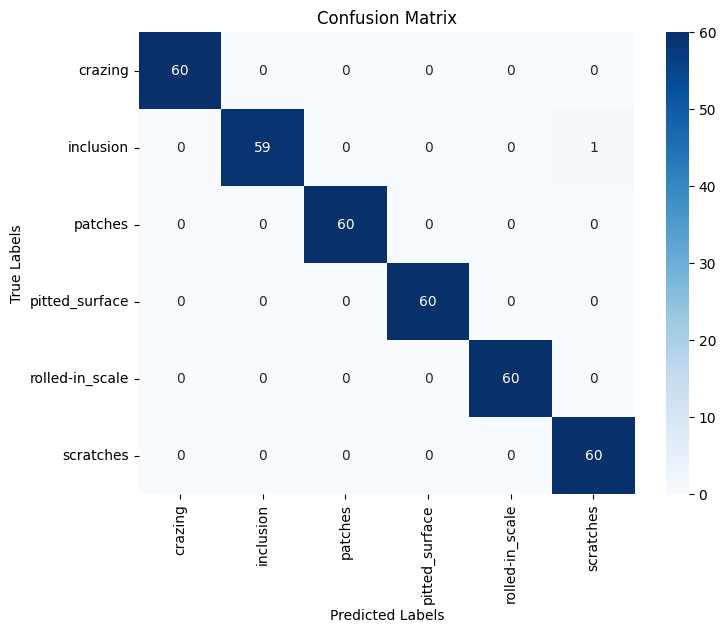

                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        60
      inclusion       1.00      0.98      0.99        60
        patches       1.00      1.00      1.00        60
 pitted_surface       1.00      1.00      1.00        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.98      1.00      0.99        60

       accuracy                           1.00       360
      macro avg       1.00      1.00      1.00       360
   weighted avg       1.00      1.00      1.00       360



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Pishbinie barchasbha
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Matrix ashoftegi
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


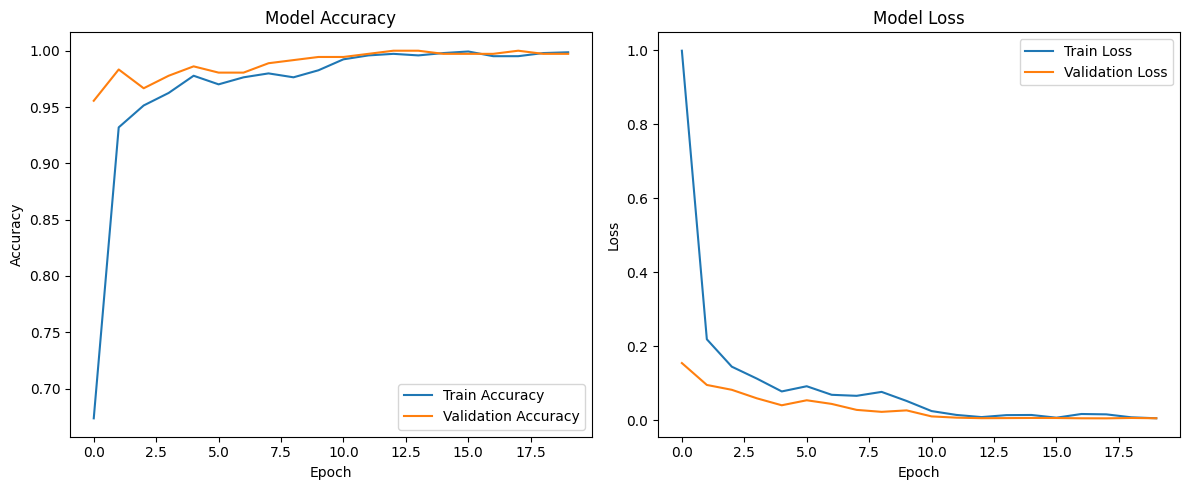

In [ ]:

def combine_histories(h1, h2):
    history = {}
    for key in h1.history.keys():
        history[key] = h1.history[key] + h2.history[key]
    return history

combined_history = combine_histories(history1, history2)

plt.figure(figsize=(12, 5))

# Deghat
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Khata
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import collections

print("Train distribution:", dict(collections.Counter(train_generator.classes)))
print("Validation distribution:", dict(collections.Counter(val_generator.classes)))


Train distribution: {np.int32(0): 240, np.int32(1): 240, np.int32(2): 240, np.int32(3): 240, np.int32(4): 240, np.int32(5): 240}
Validation distribution: {np.int32(0): 60, np.int32(1): 60, np.int32(2): 60, np.int32(3): 60, np.int32(4): 60, np.int32(5): 60}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


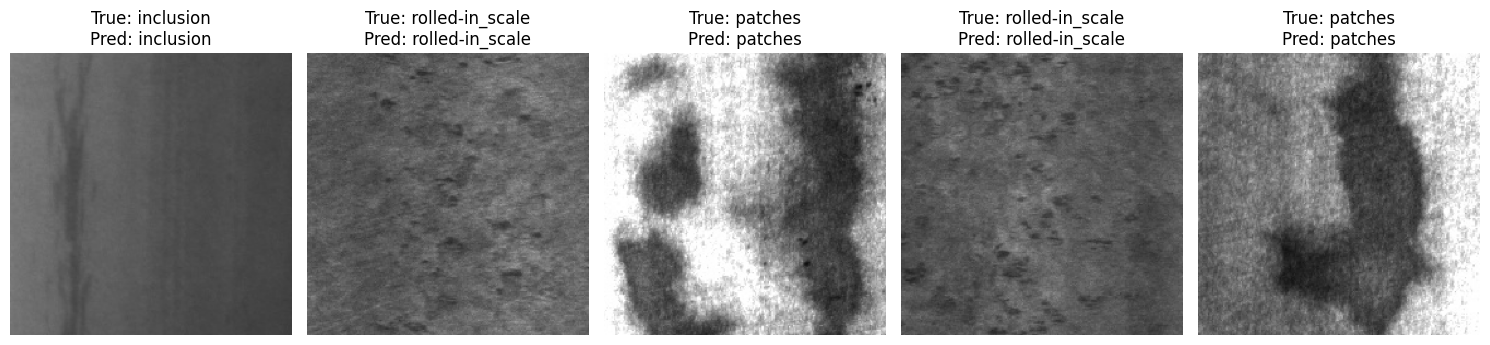

In [ ]:
# Check kardane amalkard
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# classes
class_names = list(val_generator.class_indices.keys())

import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing import image

def predict_and_plot_random_images(model, val_dir, class_names, n=5):
    plt.figure(figsize=(15, 5))

    for i in range(n):
        # Entekhabe class va tasvire tasadofi
        class_name = random.choice(class_names)
        class_path = os.path.join(val_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)

        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array_exp = np.expand_dims(img_array, axis=0)
        img_array_exp = preprocess_input(img_array_exp)

        preds = model.predict(img_array_exp)
        pred_class = class_names[np.argmax(preds)]

        plt.subplot(1, n, i + 1)
        plt.imshow(np.array(img).astype("uint8"))
        plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

predict_and_plot_random_images(model, val_dir, class_names)
